### Calculations and plotting for Figure 2 and Figures S1, S2, S5, S6

#### import statements

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
from matplotlib import colors

In [3]:
import importlib

In [4]:
from project_utils import parameters as param
from project_utils import fig_utils as figu

importlib.reload(figu)
importlib.reload(param)

<module 'project_utils.parameters' from '/oak/stanford/groups/omramom/group_members/fvdav/projects/precip_clustering/project_utils/parameters.py'>

In [5]:
import warnings
warnings.filterwarnings('ignore')
## remove warnings for cleaner output

#### plt configurations

In [6]:
figu.set_plt_rc_params()

### Read data

Midwest regional precipitation time series:

In [7]:
precip_dat = pd.read_csv("../processed_data/region_mean_precip.csv")
precip_dat['time'] = pd.to_datetime(precip_dat['time'])

In [8]:
pr_thr = precip_dat["prcp"].quantile(0.95)
precip_dat["extreme"] = 0
precip_dat.loc[precip_dat.prcp > pr_thr, 'extreme'] = 1
precip_dat["month"] = precip_dat.time.dt.month

In [9]:
pr_q90, pr_q99 = precip_dat["prcp"].quantile([0.9, 0.99])

In [10]:
print("precip 90th percentile:", pr_q90, ", 99th percentile:", pr_q99)

precip 90th percentile: 5.648203400000003 , 99th percentile: 11.112410929999992


read atmospheric variables from reanalysis: 

In [11]:
hgt_dat = xr.open_dataset("../processed_data/hgt_detrended_anomalies.nc")

In [12]:
slp_dat = xr.open_dataset("../processed_data/slp_anomalies.nc")

load class predictions:

In [13]:
class_prob = pd.read_csv("../processed_data/predicted_class_data.csv")

In [14]:
class_prob['date'] = pd.to_datetime(class_prob.date)

In [15]:
import sklearn.metrics

In [16]:
class1_recall = sklearn.metrics.recall_score(class_prob.true_y, class_prob.predicted_class)
class1_precision = sklearn.metrics.precision_score(class_prob.true_y, class_prob.predicted_class)
class1_accuracy = sklearn.metrics.accuracy_score(class_prob.true_y, class_prob.predicted_class)

In [17]:
print("Recall: ", class1_recall, ", Precision: ", class1_precision, ", Accuracy: ", class1_accuracy)

Recall:  0.9116409537166901 , Precision:  0.2837189000436491 , Accuracy:  0.8803706823925863


In [18]:
class0_precision = sklearn.metrics.precision_score(class_prob.true_y, class_prob.predicted_class, pos_label=0)

In [19]:
print("Proportion of non-EPCPs resulting in Extreme precip: ", 1-class0_precision)

Proportion of non-EPCPs resulting in Extreme precip:  0.005270643353133098


In [20]:
ones_dates = class_prob.loc[class_prob.predicted_class == 1].date
zero_dates = class_prob.loc[class_prob.predicted_class == 0].date
ones_precip = precip_dat[precip_dat.time.isin(ones_dates.values)]
zero_precip = precip_dat[precip_dat.time.isin(zero_dates.values)]

In [21]:
precip_dat["class"] = 'Class 0'
precip_dat.loc[precip_dat.time.isin(ones_dates.values), "class"] = 'Class 1'

In [22]:
hgt1 = hgt_dat.sel(time = ones_dates.values)
slp1 = slp_dat.sel(time = ones_dates.values)

load LRP results:

In [23]:
rel_dat = xr.open_dataset("../processed_data/lrp_data_all_days.nc")

### LRP dates
for main figure:

In [24]:
## best hit
a = class_prob.loc[(class_prob.true_y == 1) & (class_prob.set == "test")]
b = np.argmax(a.prob_1)
lrp_dates = [a.iloc[b].date.strftime("%Y-%m-%d")]

In [25]:
## missed extreme
a = class_prob.loc[(class_prob.true_y == 1) & (class_prob.set == "test")]
b = np.argmin(a.prob_1)
lrp_dates.append(a.iloc[b].date.strftime("%Y-%m-%d"))

In [26]:
## best null
a = class_prob.loc[(class_prob.true_y == 0) & (class_prob.set == "test")]
b = np.argmin(a.prob_1)
lrp_dates.append(a.iloc[b].date.strftime("%Y-%m-%d"))

In [27]:
lrp_dates

['1986-09-11', '2007-10-03', '1981-09-19']

for SI figure: 

In [28]:
## lowest precipitation where P(EPCP) > 0.9
a = precip_dat.loc[(class_prob.prob_1 >= 0.9) & (class_prob.set == "test")]
b = np.argmin(a.prcp)
lrp_dates_SI = [a.iloc[b].time.strftime("%Y-%m-%d")]

In [29]:
## lowest precipitation on EPCP day
a = precip_dat.loc[(class_prob.predicted_class == 1) & (class_prob.set == "test")]
b = np.argmin(a.prcp)
lrp_dates_SI.append(a.iloc[b].time.strftime("%Y-%m-%d"))

In [30]:
## Highest precipitation on non-EPCP day
a = precip_dat.loc[(class_prob.predicted_class == 0) & (class_prob.set == "test")]
b = np.argmax(a.prcp)
lrp_dates_SI.append(a.iloc[b].time.strftime("%Y-%m-%d"))

In [31]:
## "worst" false alarm
a = class_prob.loc[(class_prob.true_y == 0) & (class_prob.set == "test")]
b = np.argmax(a.prob_1)
lrp_dates_SI.append(a.iloc[b].date.strftime("%Y-%m-%d"))

In [32]:
## Highest precipitation on EPCP day
a = precip_dat.loc[(class_prob.predicted_class == 1) & (class_prob.set == "test")]
b = np.argmax(a.prcp)
lrp_dates_SI.append(a.iloc[b].time.strftime("%Y-%m-%d"))

In [33]:
lrp_dates_SI

['1996-01-26', '2007-01-27', '2008-05-30', '1993-09-13', '1997-10-13']

composite LRP data

In [34]:
rel_dat['time_dt'] = pd.to_datetime(rel_dat["time"].values)

In [35]:
lrp_ones_composite = rel_dat.sel(time = ones_dates.dt.strftime("%Y-%m-%d").values).mean(dim = "time")
lrp_zeros_composite = rel_dat.sel(time = zero_dates.dt.strftime("%Y-%m-%d").values).mean(dim = "time")

### Figure 2 (middle panel): Neural Network Performance

In [36]:
markers = ["^",  "*", "s"]
sizes = [20, 35, 25]
r = (220/255, 34/255, 71/255) ## reddish color

In [37]:
markersSI = ["X", "v", "H", "P", "D"]
sizesSI = [25, 25, 35, 25, 20]
o = (255/255, 155/255, 21/255) ## orangish color

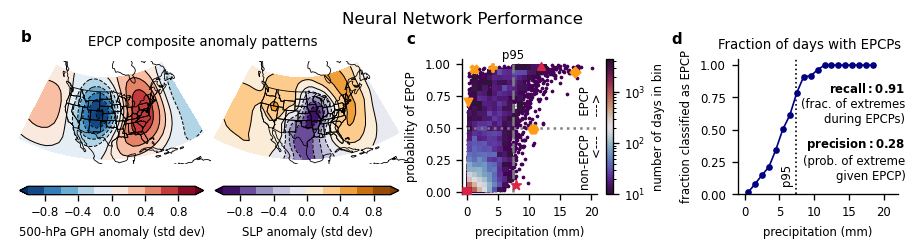

In [38]:
fig = plt.figure(figsize = (7.4, 1.95))

ct_breaks = np.arange(-1, 1.2, .2)
ax = fig.add_axes([-0.01, 0.14, 0.23, 0.63], projection = figu.mapcrs)
cf = ax.contourf(param.lons, param.lats, hgt1['hgt_anom'].mean(dim = 'time'), 
                  cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = ct_breaks, extend = "both")
ct = ax.contour(param.lons, param.lats, hgt1['hgt_anom'].mean(dim = 'time'), 
                transform = ccrs.PlateCarree(), levels = ct_breaks, colors = "black", linewidths = 0.6)
figu.format_map(ax)
figu.add_panel_label(ax, 'b', x = 0.1, y = 1.3)
fig.colorbar(cf, ax = ax, orientation = "horizontal", label = "500-hPa GPH anomaly (std dev)", shrink = 0.9)

ax = fig.add_axes([0.21, 0.14, 0.23, 0.63], projection = figu.mapcrs)
cf = ax.contourf(param.lons, param.lats, slp1['slp_anom'].mean(dim = 'time'), 
                  cmap = "PuOr_r", transform = ccrs.PlateCarree(), levels = ct_breaks, extend = "both")
ct = ax.contour(param.lons, param.lats, slp1['slp_anom'].mean(dim = 'time'), 
                transform = ccrs.PlateCarree(), levels = ct_breaks, colors = "black", linewidths = 0.6)
figu.format_map(ax)
fig.colorbar(cf, ax = ax, orientation = "horizontal", label = "SLP anomaly (std dev)", shrink = 0.9)
ax.text(x = -0.6, y = 1.15, s = 'EPCP composite anomaly patterns', transform = ax.transAxes, size = 8)

ax = fig.add_axes([0.5, 0.2, 0.19, 0.58])
i = (precip_dat.prcp > 0.1) & (class_prob.prob_1 > 0.015) ## index of individual points to plot
ax.scatter(precip_dat.loc[i, "prcp"], class_prob.loc[i, "prob_1"], 
           color = figu.fig2c_col, s = 1.5, zorder = 0)
p = ax.hist2d(precip_dat.prcp, class_prob.prob_1, bins = 25, cmin = 10, 
          norm = colors.LogNorm(), zorder = 5, cmap = figu.fig2c_cmap);
for dt, m, s in zip(lrp_dates, markers, sizes):
    ax.scatter(precip_dat.loc[precip_dat.time == dt].prcp,
               class_prob.loc[class_prob.date == dt].prob_1, 
               s = s, zorder = 20, marker = m, color = r)
for dt, m, s in zip(lrp_dates_SI, markersSI, sizesSI):
    ax.scatter(precip_dat.loc[precip_dat.time == dt].prcp,
               class_prob.loc[class_prob.date == dt].prob_1, 
               s = s, zorder = 20, marker = m, color = o)
ax.vlines(pr_thr, 0, 1, linestyle = "dashed", color = "gray", zorder = 10, linewidth = 1.5)
ax.hlines(0.5, 0, 23, linestyle = "dotted", color = "gray", zorder = 10, linewidth = 1.5)
ax.text(18, 0.52, s = "non-EPCP     EPCP       ", va = "center", 
        size = 7, zorder = 30, rotation = "vertical")
ax.text(20, 0.52, s = "<---     --->", va = "center", 
        size = 7, zorder = 30, rotation = "vertical")
ax.text(pr_thr, 1.04, s = "p95", ha = "center", 
        size = 7, zorder = 30)
ax.set(ylabel = "probability of EPCP", xlabel = "precipitation (mm)", ylim = (-0.02, 1.04), 
       xlim=(-0.8, 21), xticks = [0, 5, 10, 15, 20])
cbar = plt.colorbar(p[3], label = "number of days in bin");
figu.format_plot(ax)
figu.add_panel_label(ax, 'c', x = -0.35, y = 1.2)

ax = fig.add_axes([0.81, 0.2, 0.18, 0.58])
b = np.arange(0, 21, 1) ## histogram bins
c1_hist_data = np.histogram(ones_precip.prcp, bins = b) ## class 1 histogram data
c0_hist_data = np.histogram(zero_precip.prcp, bins = b)
ax.plot(c1_hist_data[1][:-1]+0.5, c1_hist_data[0]/(c1_hist_data[0] + c0_hist_data[0]), 
       color = figu.class1_col, marker = ".")
ax.text(pr_thr - 2.3, 0.15, s = 'p95', size = 7, rotation = 90, va = 'center')
ax.vlines(pr_thr, 0, 1.05, linestyle = "dotted", color = "k")
ax.set(ylabel = 'fraction classified as EPCP', xlabel = 'precipitation (mm)', ylim = (0, 1.05), 
       xlim = (-1, 22), xticks = [0, 5, 10, 15, 20])
ax.set_title('Fraction of days with EPCPs', x = 0.45)
ax.text(1.05, 0.53, s = r'$\bf{recall: '+ str(np.round(class1_recall, 2)) + '}$\n(frac. of extremes\nduring EPCPs)', size = 7, 
        ha = 'right', transform = ax.transAxes)
ax.text(1.05, 0.11, s = r'$\bf{precision: '+ str(np.round(class1_precision, 2)) + '}$\n(prob. of extreme\ngiven EPCP)', size = 7, 
        ha = 'right', transform = ax.transAxes)
figu.format_plot(ax)
figu.add_panel_label(ax, 'd', x = -0.35, y = 1.2)

fig.suptitle('Neural Network Performance', size = 10)

fig.savefig("../figures/figure_2_bcd.pdf")

### Figure 2 (bottom): Neural Network Interpretation (layer-wise relevance propagation)

In [39]:
panel_labels = ['e', 'f', 'g', 'h', 
                'i', 'j', 'k', 'l', 
                'm', 'n', 'o', 'p',
                 'q', 'r', 's', 't']

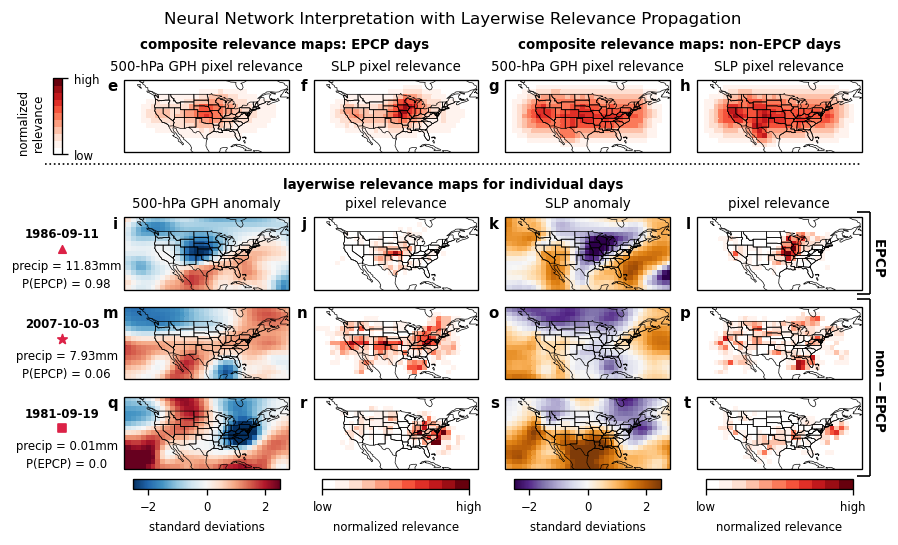

In [40]:
fig = plt.figure(figsize = (7.4, 4.4))

### composite LRP maps
ax1 = fig.add_axes([0.13, 0.72, 0.185, 0.143], projection = ccrs.PlateCarree())
p = ax1.pcolormesh(param.lons, param.lats, lrp_ones_composite['rel_hgt'], 
                      cmap = figu.whitered, transform = ccrs.PlateCarree(), vmin = 0, 
                        vmax = lrp_ones_composite.max().to_array().values.max()*1.2)
ax1.set(title = "500-hPa GPH pixel relevance")
figu.add_panel_label(ax1, "e", x = -0.04, y = 1.02)
figu.format_map_platecarree(ax1)
ax1.text(x = 0.31, y = 0.92, s = "composite relevance maps: EPCP days", weight = "bold", size = 8, 
       transform = fig.transFigure, ha = "center")

ax2 = fig.add_axes([0.343, 0.72, 0.185, 0.143], projection = ccrs.PlateCarree())
p = ax2.pcolormesh(param.lons, param.lats, lrp_ones_composite['rel_slp'], 
                      cmap = figu.whitered, transform = ccrs.PlateCarree(), vmin = 0, 
                        vmax = lrp_ones_composite.max().to_array().values.max()*1.2)
figu.add_panel_label(ax2, "f", x = -0.04, y = 1.02)
ax2.set(title = "SLP pixel relevance")
figu.format_map_platecarree(ax2)

ax3 = fig.add_axes([0.559, 0.72, 0.185, 0.143], projection = ccrs.PlateCarree())
p2 = ax3.pcolormesh(param.lons, param.lats, lrp_zeros_composite['rel_hgt'], 
                      cmap = figu.whitered, transform = ccrs.PlateCarree(), vmin = 0, 
                        vmax = lrp_zeros_composite.max().to_array().values.max()*1.2)
figu.add_panel_label(ax3, "g", x = -0.04, y = 1.02)
ax3.set(title = "500-hPa GPH pixel relevance")
figu.format_map_platecarree(ax3)


ax4 = fig.add_axes([0.775, 0.72, 0.185, 0.143], projection = ccrs.PlateCarree())
p2 = ax4.pcolormesh(param.lons, param.lats, lrp_zeros_composite['rel_slp'], 
                      cmap = figu.whitered, transform = ccrs.PlateCarree(), vmin = 0, 
                        vmax = lrp_zeros_composite.max().to_array().values.max()*1.2)
figu.add_panel_label(ax4, "h", x = -0.04, y = 1.02)
ax4.set(title = "SLP pixel relevance")
figu.format_map_platecarree(ax4)
ax1.text(x = 0.755, y = 0.92, s = "composite relevance maps: non-EPCP days", weight = "bold", size = 8, 
       transform = fig.transFigure, ha = "center")

cbaxes = fig.add_axes([0.05, 0.72, 0.01, 0.143]) 
cbar = fig.colorbar(p2, cax = cbaxes, shrink = 0.8, label = "")
cbar.ax.tick_params(labelsize=7)
cbar.set_ticks([0, lrp_zeros_composite.max().to_array().values.max()*1.2])
cbar.set_ticklabels(['low', 'high'])
ax1.text(x = 0.025, y = 0.78, s = "normalized\nrelevance", ha = "center", va = "center", 
        transform = fig.transFigure, size = 7, rotation = 90)

## plot maps for individual example days
panel_number = 0
rel_vmax = np.stack([rel_dat.sel(time = lrp_dates).quantile(0.99, dim = ["lat", "lon"])['rel_hgt'], 
          rel_dat.sel(time = lrp_dates).quantile(0.99, dim = ["lat", "lon"])['rel_slp']]).max(axis = 0)*1.5

for j, dt, m, s in zip(range(3), lrp_dates, markers, sizes):
    ax1 = fig.add_axes([0.13, 0.46-j*0.17, 0.185, 0.143], projection = ccrs.PlateCarree())
    p1 = ax1.pcolormesh(param.lons, param.lats, hgt_dat.sel(time = dt)['hgt_anom'], 
                      cmap = "RdBu_r", transform = ccrs.PlateCarree(), vmin = -2.5, vmax = 2.5)
    figu.format_map_platecarree(ax1)
    figu.add_panel_label(ax1, chr(105+panel_number), x = -0.04, y = 1.02)
    panel_number += 1
    
    ax2 = fig.add_axes([0.343, 0.46-j*0.17, 0.185, 0.143], projection = ccrs.PlateCarree())
    p2 = ax2.pcolormesh(param.lons, param.lats, rel_dat.sel(time = dt)['rel_hgt'], 
                      cmap = figu.whitered, transform = ccrs.PlateCarree(), vmin = 0, 
                        vmax = rel_vmax[j]*0.9)
    figu.format_map_platecarree(ax2)
    figu.add_panel_label(ax2, chr(105+panel_number), x = -0.04, y = 1.02)
    panel_number += 1
    
    ax3 = fig.add_axes([0.559, 0.46-j*0.17, 0.185, 0.143], projection = ccrs.PlateCarree())
    p3 = ax3.pcolormesh(param.lons, param.lats, slp_dat.sel(time = dt)['slp_anom'], 
                      cmap = "PuOr_r", transform = ccrs.PlateCarree(), vmin = -2.5, vmax = 2.5)
    figu.format_map_platecarree(ax3)
    figu.add_panel_label(ax3, chr(105+panel_number), x = -0.04, y = 1.02)
    panel_number += 1
    
    ax4 = fig.add_axes([0.775, 0.46-j*0.17, 0.185, 0.143], projection = ccrs.PlateCarree())
    p4 = ax4.pcolormesh(param.lons, param.lats, rel_dat.sel(time = dt)['rel_slp'], 
                      cmap = figu.whitered, transform = ccrs.PlateCarree(), vmin = 0, vmax = rel_vmax[j]*0.9)
    figu.format_map_platecarree(ax4)
    figu.add_panel_label(ax4, chr(105+panel_number), x = -0.04, y = 1.02)
    panel_number += 1
    
    ax1.text(0.06, 0.58-j*0.17, dt, weight = 'bold', size = 7, 
         transform = fig.transFigure, va = 'top', ha = 'center')
    ax1.scatter(0.06, 0.54-j*0.17, marker = m, s = s, color = r, transform = fig.transFigure, clip_on=False)
    ax1.text(0.065, 0.52-j*0.17, "precip = " + 
        str(np.round(precip_dat.loc[precip_dat.time == dt].prcp.values[0],2)) + 
         'mm\nP(EPCP) = ' + str(np.round(class_prob.loc[class_prob.date == dt].prob_1.values[0],2)),
         size = 7, transform = fig.transFigure, va = 'top', ha = 'center', linespacing = 1.5)
    
    if (j == 0): 
        ax1.set_title("500-hPa GPH anomaly")
        ax2.set_title("pixel relevance")
        ax3.set_title("SLP anomaly")
        ax4.set_title("pixel relevance")

## text annotation and colorbar formatting 
ax1.text(x = 0.5, y = 0.655, s = "layerwise relevance maps for individual days", weight = "bold", size = 8, 
       transform = fig.transFigure, ha = "center")
figu.add_square_bracket(fig, ax2, 0.955, 0.97, 0.455, 0.61, r'  $\bf{EPCP}$')
figu.add_square_bracket(fig, ax4, 0.955, 0.97, 0.11, 0.445, r' $\bf{non-EPCP}$')

cbaxes = fig.add_axes([0.14, 0.086, 0.165, 0.019]) 
cbar = fig.colorbar(p1, cax = cbaxes, label = 'standard deviations', orientation = "horizontal")
cbar.ax.tick_params(labelsize=7)

cbaxes = fig.add_axes([0.353, 0.086, 0.165, 0.019]) 
cbar = fig.colorbar(p2, cax = cbaxes, shrink = 0.8, label = "normalized relevance", orientation = "horizontal")
cbar.ax.tick_params(labelsize=7)
cbar.set_ticks([0, np.max(rel_vmax[2])*0.9])
cbar.set_ticklabels(['low', 'high'])

cbaxes = fig.add_axes([0.569, 0.086, 0.165, 0.019]) 
cbar = fig.colorbar(p3, cax = cbaxes, shrink = 0.8, label = 'standard deviations', orientation = "horizontal")
cbar.ax.tick_params(labelsize=7)

cbaxes = fig.add_axes([0.785, 0.086, 0.165, 0.019]) 
cbar = fig.colorbar(p2, cax = cbaxes, shrink = 0.8, label = "normalized relevance", orientation = "horizontal")
cbar.ax.tick_params(labelsize=7)
cbar.set_ticks([0, np.max(rel_vmax[2])*0.9])
cbar.set_ticklabels(['low', 'high'])

ax1.plot([0.04, 0.96], [0.7, 0.7], transform = fig.transFigure, clip_on=False, color = "k", linestyle = "dotted")

fig.suptitle("Neural Network Interpretation with Layerwise Relevance Propagation", size = 10, y = 0.99)
fig.savefig("../figures/figure_2_e-t.pdf")

### Extra: example input images for network diagram (Fig. 2a)

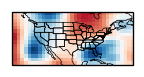

In [41]:
fig, ax = plt.subplots(figsize = (1.3, 0.9), subplot_kw={'projection': ccrs.PlateCarree()})
p = ax.pcolormesh(param.lons, param.lats, 
              hgt_dat.isel(time = 1000)['hgt_anom'], cmap = "RdBu_r", transform = ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth = 0.4)
ax.add_feature(cfeature.STATES.with_scale('110m'), linewidth = 0.4)
ax.set_extent([-140, -55, 19, 48]) ## not sure why the extent doesn't line up perfectly for the y extent
fig.savefig("../figures/hgt_input_example.pdf", bbox_inches = "tight")

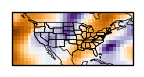

In [42]:
fig, ax = plt.subplots(figsize = (1.3, 0.9), subplot_kw={'projection': ccrs.PlateCarree()})
p = ax.pcolormesh(param.lons, param.lats, 
              slp_dat.isel(time = 1000)['slp_anom'], cmap = "PuOr_r", transform = ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth = 0.4)
ax.add_feature(cfeature.STATES.with_scale('110m'), linewidth = 0.4)
ax.set_extent([-140, -55, 19, 48]) ## not sure why the extent doesn't line up perfectly for the y extent
fig.savefig("../figures/slp_input_example.pdf", bbox_inches = "tight")

### Figure S1: Seasonal patterns

In [43]:
xticklab = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]

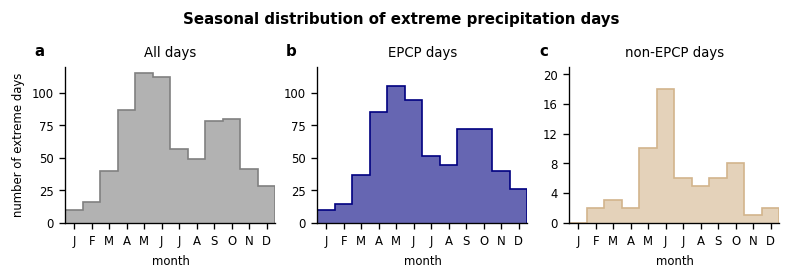

In [44]:
fig = plt.figure(figsize = (7, 2))

ax = fig.add_axes([0.1, 0.1, 0.25, 0.65])
ax.hist(precip_dat.loc[precip_dat.extreme == 1].month, bins = np.arange(0.5, 13.5, 1), 
        color = "grey", alpha = 0.6)
ax.hist(precip_dat.loc[precip_dat.extreme == 1].month, bins = np.arange(0.5, 13.5, 1), 
        color = "grey", histtype = "step")
ax.set(xlim = (0.5, 12.5), xlabel = "month", ylabel = "number of extreme days", 
       xticks = np.arange(1,13), xticklabels = xticklab,
       ylim = (0, 120), yticks = np.arange(0, 125, 25))
ax.set_title("All days")
figu.format_plot(ax)
figu.add_panel_label(ax, "a")

ax = fig.add_axes([0.4, 0.1, 0.25, 0.65])
ax.hist(precip_dat.loc[(precip_dat.extreme == 1) & (precip_dat["class"] == "Class 1")].month, bins = np.arange(0.5, 13.5, 1), 
       color = figu.class1_col, alpha = 0.6)
ax.hist(precip_dat.loc[(precip_dat.extreme == 1) & (precip_dat["class"] == "Class 1")].month, bins = np.arange(0.5, 13.5, 1), 
       color = figu.class1_col, histtype = "step")
ax.set(xlim = (0.5, 12.5), xlabel = "month", ylim = (0, 120), xticks = np.arange(1,13), xticklabels = xticklab,
       yticks = np.arange(0, 125, 25))
ax.set_title("EPCP days")
figu.add_panel_label(ax, "b")
figu.format_plot(ax)

ax = fig.add_axes([0.7, 0.1, 0.25, 0.65])
ax.hist(precip_dat.loc[(precip_dat.extreme == 1) & (precip_dat["class"] == "Class 0")].month, bins = np.arange(0.5, 13.5, 1), 
       color = figu.class0_col, alpha = 0.6)
ax.hist(precip_dat.loc[(precip_dat.extreme == 1) & (precip_dat["class"] == "Class 0")].month, bins = np.arange(0.5, 13.5, 1), 
       color = figu.class0_col, histtype = "step")
ax.set(xlim = (0.5, 12.5), xlabel = "month", xticks = np.arange(1,13), xticklabels = xticklab, 
       ylim = (0, 21), yticks = np.arange(0, 24, 4))
ax.set_title("non-EPCP days")
figu.add_panel_label(ax, "c")
figu.format_plot(ax)

fig.suptitle("Seasonal distribution of extreme precipitation days", weight = "bold", size = 9)
fig.savefig("../figures/figure_S1.pdf")

### Figure S2: model training history

In [45]:
with open("../processed_data/training_history.csv", mode = "r") as f:
    history = pd.read_csv(f, index_col = 0)
    
with open("../processed_data/training_history_hgt_only.csv", mode = "r") as f:
    history_hgt = pd.read_csv(f, index_col = 0)

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score

In [47]:
y_train = class_prob.loc[class_prob.set == 'train', "true_y"]
y_test = class_prob.loc[class_prob.set == 'test', "true_y"]

train_predict = class_prob.loc[class_prob.set == 'train',"prob_1"]
test_predict = class_prob.loc[class_prob.set == 'test',"prob_1"]

In [48]:
## ROC curve
train_roc = roc_curve(y_train, train_predict)
test_roc = roc_curve(y_test, test_predict)
all_roc = roc_curve(class_prob.true_y, class_prob.prob_1)

train_auc = roc_auc_score(y_train, train_predict)
test_auc = roc_auc_score(y_test, test_predict)
all_auc = roc_auc_score(class_prob.true_y, class_prob.prob_1)

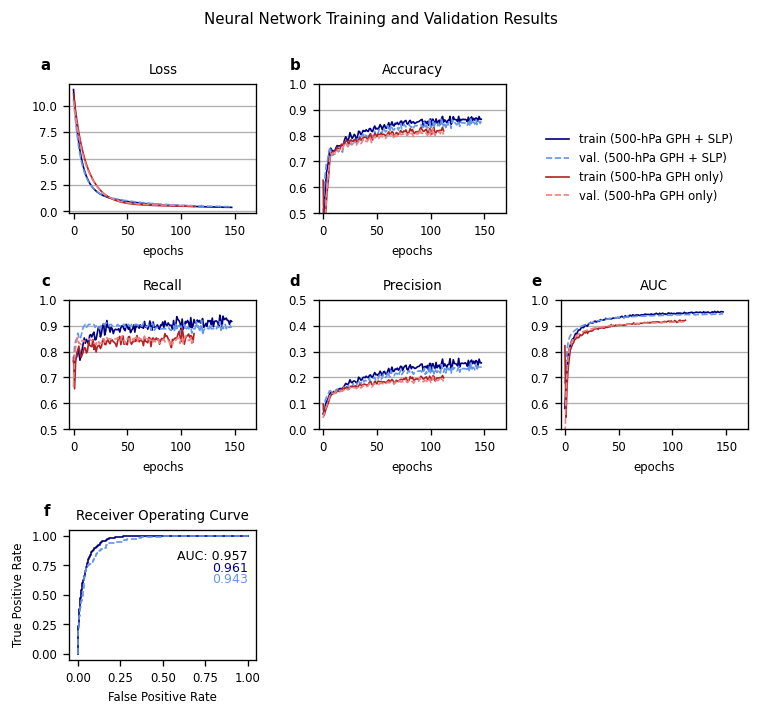

In [49]:
fig = plt.figure(figsize = (6.5, 6))

train_col = figu.train_col
val_col = figu.val_col
hgt_train_col = "firebrick"
hgt_val_col = "lightcoral"

ax = fig.add_axes([0.1, 0.7, 0.24, 0.18])
ax.plot(history['loss'], label = 'train (500-hPa GPH + SLP)', color = train_col)
ax.plot(history['val_loss'], linestyle = "dashed", label = 'val. (500-hPa GPH + SLP)', color = val_col)
ax.plot(history_hgt['loss'], label = 'train (500-hPa GPH only)', color = hgt_train_col)
ax.plot(history_hgt['val_loss'], linestyle = "dashed", label = 'val. (500-hPa GPH only)', color = hgt_val_col)
ax.set(title = "Loss", xlabel = 'epochs', xlim = (-4, 170))
ax.grid(which = 'major', axis = 'y')
ax.legend(bbox_to_anchor = (3.6, 0.7), frameon=False)
figu.add_panel_label(ax, 'a',  y = 1.2)
   
ax = fig.add_axes([0.42, 0.7, 0.24, 0.18])
ax.grid(which = 'major', axis = 'y')
ax.plot(history['accuracy'], label = 'training', color = train_col)
ax.plot(history['val_accuracy'], linestyle = "dashed", label = 'validation', color = val_col)
ax.plot(history_hgt['accuracy'], label = 'training', color = hgt_train_col)
ax.plot(history_hgt['val_accuracy'], linestyle = "dashed", label = 'validation', color = hgt_val_col)
ax.set(ylim = (0.5,1), xlim = (-4, 170), title = "Accuracy", xlabel = 'epochs')
figu.add_panel_label(ax, 'b',  y = 1.2)

ax = fig.add_axes([0.1, 0.4, 0.24, 0.18])
ax.grid(which = 'major', axis = 'y')
ax.plot(history['recall'], color = train_col)
ax.plot(history['val_recall'], linestyle = "dashed", color = val_col)
ax.plot(history_hgt['recall'], color = hgt_train_col)
ax.plot(history_hgt['val_recall'], linestyle = "dashed", color = hgt_val_col)
ax.set(ylim = (0.5,1),xlim = (-4, 170), title = "Recall", xlabel = 'epochs')
figu.add_panel_label(ax, 'c',  y = 1.2)

ax = fig.add_axes([0.42, 0.4, 0.24, 0.18])
ax.grid(which = 'major', axis = 'y')
ax.plot(history['precision'], color = train_col)
ax.plot(history['val_precision'], linestyle = "dashed", color = val_col)
ax.plot(history_hgt['precision'], color = hgt_train_col)
ax.plot(history_hgt['val_precision'], linestyle = "dashed", color = hgt_val_col)
ax.set(ylim = (0,0.5), xlim = (-4, 170), title = "Precision", xlabel = 'epochs')
figu.add_panel_label(ax, 'd',  y = 1.2)

ax = fig.add_axes([0.73, 0.4, 0.24, 0.18])
ax.grid(which = 'major', axis = 'y')
ax.plot(history['auc'], color = train_col)
ax.plot(history['val_auc'], linestyle = "dashed", color = val_col)
ax.plot(history_hgt['auc'], color = hgt_train_col)
ax.plot(history_hgt['val_auc'], linestyle = "dashed", color = hgt_val_col)
ax.set(ylim = (0.5,1), xlim = (-4, 170), title = "AUC", xlabel = 'epochs')
figu.add_panel_label(ax, 'e',  y = 1.2)

ax = fig.add_axes([0.1, 0.08, 0.24, 0.18])
ax.plot(train_roc[0], train_roc[1], color = figu.train_col, label = "train")
ax.plot(test_roc[0], test_roc[1], color = figu.val_col, linestyle = "dashed", label = "val.")
ax.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate', title = 'Receiver Operating Curve')
ax.text(x = 1, y = 0.8, s = "AUC: " + str(np.round(all_auc, 3)), size = 7.5, ha = "right")
ax.text(x = 1, y = 0.7, s = str(np.round(train_auc, 3)), color = figu.train_col, size = 7.5, ha = "right")
ax.text(x = 1, y = 0.6, s = str(np.round(test_auc, 3)), color = figu.val_col, size = 7.5, ha = "right")
figu.add_panel_label(ax, 'f',  y = 1.2)

fig.suptitle("Neural Network Training and Validation Results", size = 9)
fig.savefig("../figures/figure_S2.pdf")

### Figure S5 - top panels

In [50]:
season_months = [[12, 1, 2], 
                 [3, 4, 5], 
                 [6, 7, 8], 
                 [9, 10, 11]]
season_names = ["DJF", "MAM", "JJA", "SON"]

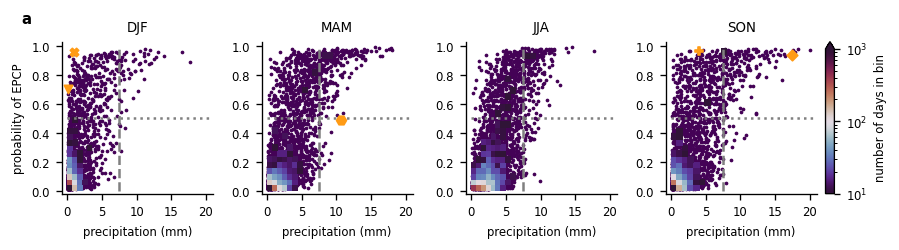

In [51]:
fig = plt.figure(figsize = (7.4, 1.95))

ax1 = fig.add_axes([0.06, 0.2, 0.17, 0.65])
ax2 = fig.add_axes([0.285, 0.2, 0.17, 0.65])
ax3 = fig.add_axes([0.515, 0.2, 0.17, 0.65])
ax4 = fig.add_axes([0.74, 0.2, 0.17, 0.65])
axes = [ax1, ax2, ax3, ax4]

for k, (mons, name, ax)in enumerate(zip(season_months, season_names, axes)):
    i = (precip_dat.prcp > 0.1) & (class_prob.prob_1 > 0.015) & (precip_dat.time.dt.month.isin(mons))
    j = precip_dat.time.dt.month.isin(mons)
    ax.scatter(precip_dat.loc[i, "prcp"], class_prob.loc[i, "prob_1"], 
           color = figu.fig2c_col, s = 1.5, zorder = 0)
    p = ax.hist2d(precip_dat.loc[j, "prcp"], class_prob.loc[j, "prob_1"], bins = 25, cmin = 10, 
          norm = colors.LogNorm(vmax = 1000), zorder = 5, cmap = figu.fig2c_cmap);
    for dt, z, z2 in zip(lrp_dates_SI, markersSI, sizesSI):
        if int(dt[5:7]) in mons:
            ax.scatter(precip_dat.loc[precip_dat.time == dt, "prcp"], 
                       class_prob.loc[class_prob.date == dt, "prob_1"], 
                       s = z2, zorder = 20, marker = z, color = o)
    ax.vlines(pr_thr, 0, 1, linestyle = "dashed", color = "gray", zorder = 10, linewidth = 1.5)
    ax.hlines(0.5, 0, 23, linestyle = "dotted", color = "gray", zorder = 10, linewidth = 1.5)
    ax.set(xlabel = "precipitation (mm)", ylim = (-0.02, 1.03), 
       xlim=(-0.8, 21), title = name, xticks = [0, 5, 10, 15, 20])
    if k == 0:
        ax.set_ylabel("probability of EPCP")
        figu.add_panel_label(ax, "a", x = -0.2, y = 1.2)
    figu.format_plot(ax)
    

cbaxes = fig.add_axes([0.92, 0.2, 0.01, 0.65]) 
cbar = fig.colorbar(p[3], cax = cbaxes, shrink = 0.8, label = "number of days in bin", extend = "max")

fig.savefig("../figures/figure_S5_a.pdf")

### Figure S5 - middle panels

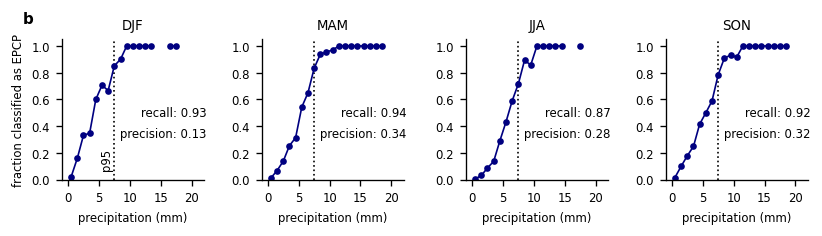

In [52]:
fig = plt.figure(figsize = (7.4, 1.8))

ax1 = fig.add_axes([0.06, 0.2, 0.16, 0.65])
ax2 = fig.add_axes([0.285, 0.2, 0.16, 0.65])
ax3 = fig.add_axes([0.515, 0.2, 0.16, 0.65])
ax4 = fig.add_axes([0.74, 0.2, 0.16, 0.65])
axes = [ax1, ax2, ax3, ax4]

for k, (mons, name, ax) in enumerate(zip(season_months, season_names, axes)):

    recall = sklearn.metrics.recall_score(class_prob[class_prob.date.dt.month.isin(mons)].true_y, 
                                        class_prob[class_prob.date.dt.month.isin(mons)].predicted_class)
    precision = sklearn.metrics.precision_score(class_prob[class_prob.date.dt.month.isin(mons)].true_y, 
                                        class_prob[class_prob.date.dt.month.isin(mons)].predicted_class)
    b = np.arange(0, 21, 1)
    c1_hist_data = np.histogram(ones_precip[ones_precip.time.dt.month.isin(mons)].prcp, bins = b)
    c0_hist_data = np.histogram(zero_precip[zero_precip.time.dt.month.isin(mons)].prcp, bins = b)
    ax.plot(c1_hist_data[1][:-1]+0.5, c1_hist_data[0]/(c1_hist_data[0] + c0_hist_data[0]), 
       color = figu.class1_col, marker = ".")
    ax.vlines(pr_thr, 0, 1.05, linestyle = "dotted", color = "k")
    ax.set(xlabel = 'precipitation (mm)', ylim = (0, 1.05), 
       xlim = (-1, 22), xticks = [0, 5, 10, 15, 20], title = name)
    if (k == 0): 
        ax.set_ylabel('fraction classified as EPCP') 
        ax.text(pr_thr - 2.3, 0.15, s = 'p95', size = 7, rotation = 90, va = 'center')
        figu.add_panel_label(ax, "b", x = -0.2, y = 1.2)
    ax.text(1.02, 0.45, s = 'recall: ' + str(np.round(recall, 2)), size = 7, 
        ha = 'right', transform = ax.transAxes)
    ax.text(1.02, 0.3, s = 'precision: ' + str(np.round(precision, 2)), size = 7, 
        ha = 'right', transform = ax.transAxes)
    figu.format_plot(ax)

    
fig.savefig("../figures/figure_S5_b.pdf")

### Figure S5 - LRP panels

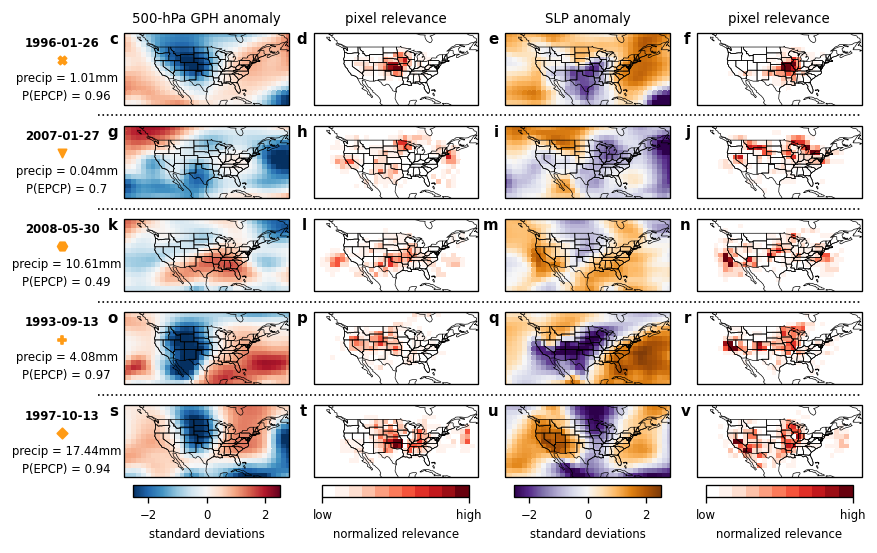

In [53]:
fig = plt.figure(figsize = (7.4, 4.85))

rel_vmax = np.stack([rel_dat.sel(time = lrp_dates_SI).quantile(0.99, dim = ["lat", "lon"])['rel_hgt'], 
          rel_dat.sel(time = lrp_dates_SI).quantile(0.99, dim = ["lat", "lon"])['rel_slp']]).max(axis = 0)*1.5
panel_number = 0
for j, dt, m, s in zip(range(5), lrp_dates_SI, markersSI, sizesSI):
    ax1 = fig.add_axes([0.13, 0.76-j*0.16, 0.185, 0.13], projection = ccrs.PlateCarree())
    p1 = ax1.pcolormesh(param.lons, param.lats, hgt_dat.sel(time = dt)['hgt_anom'], 
                      cmap = "RdBu_r", transform = ccrs.PlateCarree(), vmin = -2.5, vmax = 2.5)
    figu.format_map_platecarree(ax1)
    figu.add_panel_label(ax1, chr(99+panel_number), x = -0.04, y = 1.02)
    panel_number += 1
    
    ax2 = fig.add_axes([0.343, 0.76-j*0.16, 0.185, 0.13], projection = ccrs.PlateCarree())
    p2 = ax2.pcolormesh(param.lons, param.lats, rel_dat.sel(time = dt)['rel_hgt'], 
                      cmap = figu.whitered, transform = ccrs.PlateCarree(), vmin = 0, 
                        vmax = rel_vmax[j]*0.9)
    figu.format_map_platecarree(ax2)
    figu.add_panel_label(ax2, chr(99+panel_number), x = -0.04, y = 1.02)
    panel_number += 1
    
    ax3 = fig.add_axes([0.559, 0.76-j*0.16, 0.185, 0.13], projection = ccrs.PlateCarree())
    p3 = ax3.pcolormesh(param.lons, param.lats, slp_dat.sel(time = dt)['slp_anom'], 
                      cmap = "PuOr_r", transform = ccrs.PlateCarree(), vmin = -2.5, vmax = 2.5)
    figu.format_map_platecarree(ax3)
    figu.add_panel_label(ax3, chr(99+panel_number), x = -0.04, y = 1.02)
    panel_number += 1
    
    ax4 = fig.add_axes([0.775, 0.76-j*0.16, 0.185, 0.13], projection = ccrs.PlateCarree())
    p4 = ax4.pcolormesh(param.lons, param.lats, rel_dat.sel(time = dt)['rel_slp'], 
                      cmap = figu.whitered, transform = ccrs.PlateCarree(), vmin = 0, vmax = rel_vmax[j]*0.9)
    figu.format_map_platecarree(ax4)
    figu.add_panel_label(ax4, chr(99+panel_number), x = -0.04, y = 1.02)
    panel_number += 1
    
    ax1.text(0.06, 0.88-j*0.16, dt, weight = 'bold', size = 7, 
         transform = fig.transFigure, va = 'top', ha = 'center')
    ax1.scatter(0.06, 0.84-j*0.16, marker = m, s = s, color = o, transform = fig.transFigure, clip_on=False)
    ax1.text(0.065, 0.82-j*0.16, "precip = " + 
        str(np.round(precip_dat.loc[precip_dat.time == dt].prcp.values[0],2)) + 
         'mm\nP(EPCP) = ' + str(np.round(class_prob.loc[class_prob.date == dt].prob_1.values[0],2)),
         size = 7, transform = fig.transFigure, va = 'top', ha = 'center', linespacing = 1.5)
    
    if (j == 0): 
        ax1.set_title("500-hPa GPH anomaly")
        ax2.set_title("pixel relevance")
        ax3.set_title("SLP anomaly")
        ax4.set_title("pixel relevance")

cbaxes = fig.add_axes([0.14, 0.09, 0.165, 0.02]) 
cbar = fig.colorbar(p1, cax = cbaxes, label = 'standard deviations', orientation = "horizontal")
cbar.ax.tick_params(labelsize=7)

cbaxes = fig.add_axes([0.353, 0.09, 0.165, 0.02]) 
cbar = fig.colorbar(p2, cax = cbaxes, shrink = 0.8, label = "normalized relevance", orientation = "horizontal")
cbar.ax.tick_params(labelsize=7)
cbar.set_ticks([0, np.max(rel_vmax[j])*0.9])
cbar.set_ticklabels(['low', 'high'])

cbaxes = fig.add_axes([0.569, 0.09, 0.165, 0.02]) 
cbar = fig.colorbar(p3, cax = cbaxes, shrink = 0.8, label = 'standard deviations', orientation = "horizontal")
cbar.ax.tick_params(labelsize=7)

cbaxes = fig.add_axes([0.785, 0.09, 0.165, 0.02]) 
cbar = fig.colorbar(p2, cax = cbaxes, shrink = 0.8, label = "normalized relevance", orientation = "horizontal")
cbar.ax.tick_params(labelsize=7)
cbar.set_ticks([0, np.max(rel_vmax[j])*0.9])
cbar.set_ticklabels(['low', 'high'])

ax1.plot([0.1, 0.96], [0.745, 0.745], transform = fig.transFigure, clip_on=False, color = "k", linestyle = "dotted")
ax1.plot([0.1, 0.96], [0.585, 0.585], transform = fig.transFigure, clip_on=False, color = "k", linestyle = "dotted")
ax1.plot([0.1, 0.96], [0.425, 0.425], transform = fig.transFigure, clip_on=False, color = "k", linestyle = "dotted")
ax1.plot([0.1, 0.96], [0.265, 0.265], transform = fig.transFigure, clip_on=False, color = "k", linestyle = "dotted")

fig.savefig("../figures/figure_S5_c-v.pdf")

### Fig. S6 - EPCP vs. Non-EPCP precipitation distribution

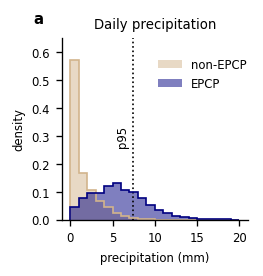

In [54]:
fig, ax = plt.subplots(figsize = (2, 2))
b = np.arange(0, 21, 1)

ax.hist(zero_precip.prcp, density = True, histtype = "stepfilled", alpha = 0.5, label = "non-EPCP", 
        color = figu.class0_col, bins = b)
ax.hist(zero_precip.prcp, density = True, histtype = "step", color = figu.class0_col, bins = b)
ax.hist(ones_precip.prcp, density = True, histtype = "stepfilled", alpha = 0.5, label = "EPCP", 
        color = figu.class1_col, bins = b)
ax.text(pr_thr - 2, 0.3, s = 'p95', size = 7, rotation = 90, va = 'center')
ax.hist(ones_precip.prcp, density = True, histtype = "step", color = figu.class1_col, bins = b)
ax.vlines(pr_thr, 0, 1.1, linestyle = "dotted", color = "k")
ax.set(ylabel = "density", xlabel = "precipitation (mm)", title = "Daily precipitation", ylim = (0,0.65))
ax.legend(bbox_to_anchor = (1.05, 0.95), loc = "upper right", frameon=False)
figu.format_plot(ax)
figu.add_panel_label(ax, "a")
fig.savefig("../figures/figure_S6_a.pdf", bbox_inches = "tight")

In [55]:
## calculations for Fig. S6b 

b = list(np.arange(0, 20, 2)) + [21] ## bins

o50 = np.histogram(precip_dat.loc[class_prob.prob_1 >= 0.5].prcp, bins = b)
o75 = np.histogram(precip_dat.loc[class_prob.prob_1 >= 0.75].prcp, bins = b)
o90 = np.histogram(precip_dat.loc[class_prob.prob_1 >= 0.9].prcp, bins = b)

all_hist = np.histogram(precip_dat.prcp, bins = b)

a = o50[0]/all_hist[0]  ## calculate proportion for each bin and threshold
b = o75[0]/all_hist[0]
c = o90[0]/all_hist[0]

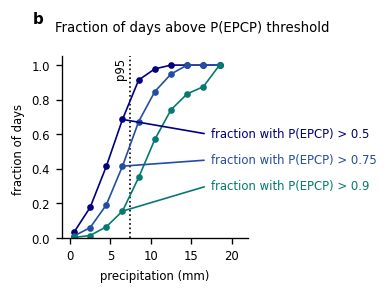

In [56]:
fig, ax = plt.subplots(figsize = (2, 2))

ax.plot(all_hist[1][:-1]+0.5, a, 
       color = figu.class1_col, marker = ".")
ax.plot(all_hist[1][:-1]+0.5, b, marker = ".", color = figu.epcp75_col)
ax.plot(all_hist[1][:-1]+0.5, c, marker = ".", color = figu.epcp90_col)
ax.text(pr_thr - 2, 0.98, s = 'p95', size = 7, rotation = 90, va = 'center')
ax.vlines(pr_thr, 0, 1.05, linestyle = "dotted", color = "k")
ax.set(ylabel = 'fraction of days ', 
       xlabel = 'precipitation (mm)', ylim = (0, 1.05), 
       xlim = (-1, 22), xticks = [0, 5, 10, 15, 20])
ax.set_title("Fraction of days above P(EPCP) threshold", size = 8, pad = 15, x = 0.7)
figu.format_plot(ax)
figu.add_panel_label(ax, "b", y = 1.25)

## label lines
ax.annotate('', xy=(all_hist[1][3]+0.5, c[3]), xytext=(17, 0.3), size = 7,
            arrowprops=dict(arrowstyle="-", color = figu.epcp90_col))
ax.text(17.5, 0.3, 'fraction with P(EPCP) > 0.9', va = "center", size = 7, color = figu.epcp90_col)

ax.annotate('', xy=(all_hist[1][3]+0.5, b[3]), xytext=(17, 0.45), size = 7,
            arrowprops=dict(arrowstyle="-", color = figu.epcp75_col))
ax.text(17.5, 0.45, 'fraction with P(EPCP) > 0.75', va = "center", size = 7, color = figu.epcp75_col)

ax.annotate('', xy=(all_hist[1][3]+0.5, a[3]), xytext=(17, 0.6), size = 7,
            arrowprops=dict(arrowstyle="-", color = figu.class1_col))
ax.text(17.5, 0.6, 'fraction with P(EPCP) > 0.5', va = "center", size = 7, color = figu.class1_col)
fig.savefig("../figures/figure_S6b.pdf", bbox_inches = "tight")

In [57]:
## calculations for Fig. S6c 
b = np.arange(0, 1.1, .1) ## bins 
o95 = np.histogram(class_prob.loc[precip_dat.prcp >= pr_thr].prob_1, bins = b)
o90 = np.histogram(class_prob.loc[precip_dat.prcp >= pr_q90].prob_1, bins = b)
o99 = np.histogram(class_prob.loc[precip_dat.prcp >= pr_q99].prob_1, bins = b)

all_hist = np.histogram(class_prob.prob_1, bins = b)

a = o95[0]/all_hist[0] ## calculation proportion for each bin
b = o90[0]/all_hist[0]
c = o99[0]/all_hist[0]

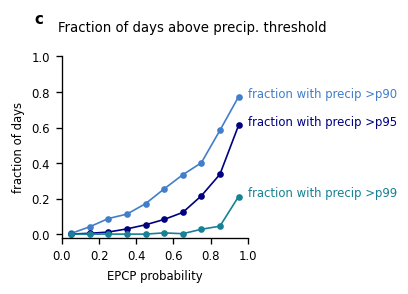

In [58]:
fig, ax = plt.subplots(figsize = (2, 2))

ax.plot(all_hist[1][:-1]+0.05, b,  marker = ".", color = figu.p90_col)
ax.plot(all_hist[1][:-1]+0.05, a, 
       color = figu.class1_col, marker = ".")
ax.plot(all_hist[1][:-1]+0.05, c,  marker = ".", color = figu.p99_col)
ax.set(xlim = (0, 1), ylim = (-0.02,1), xlabel = "EPCP probability", 
       ylabel = "fraction of days")
ax.set_title("Fraction of days above precip. threshold", size = 8, pad = 15, x = 0.7)
ax.text(1, b[-1], "fraction with precip >p90", color = figu.p90_col, size = 7)
ax.text(1, a[-1], "fraction with precip >p95", color = figu.class1_col, size = 7)
ax.text(1, c[-1], "fraction with precip >p99", color = figu.p99_col, size = 7)
figu.format_plot(ax)
figu.add_panel_label(ax, "c", y = 1.25)

fig.savefig("../figures/figure_S6_c.pdf", bbox_inches = "tight")

### Heatmap presentation figures

In [59]:
plt.rc('axes', titlesize=14)     # fontsize of the axes titles (i.e. title of each panel)
plt.rc('axes', labelsize=14)    # fontsize of the x and y axis labels
plt.rc('xtick', labelsize=12)    # fontsize of the x tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the y tick labels
plt.rc('figure', titlesize = 14)
plt.rc('legend', fontsize=12)
plt.rc('legend', title_fontsize=12)

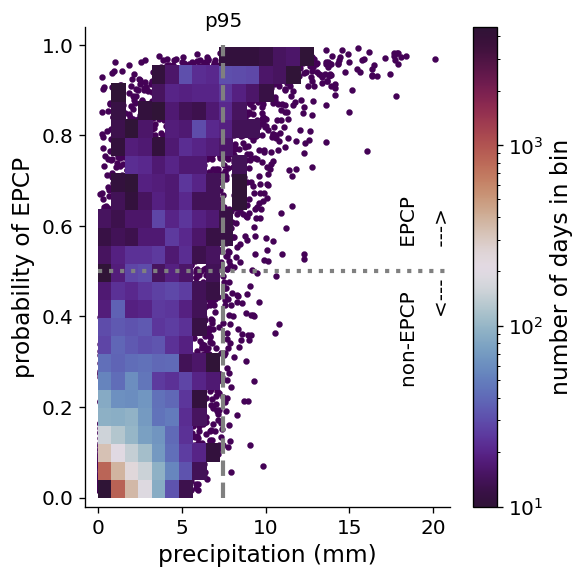

In [60]:
fig = plt.figure(figsize = (5,5))

ax = fig.add_axes([0.15, 0.12, 0.76, 0.8])
i = (precip_dat.prcp > 0.1) & (class_prob.prob_1 > 0.015)
ax.scatter(precip_dat.loc[i, "prcp"], class_prob.loc[i, "prob_1"], 
           color = figu.fig2c_col, s = 8, zorder = 0)
p = ax.hist2d(precip_dat.prcp, class_prob.prob_1, bins = 25, cmin = 10, 
          norm = colors.LogNorm(), zorder = 5, cmap = figu.fig2c_cmap);
ax.vlines(pr_thr, 0, 1, linestyle = "dashed", color = "gray", zorder = 10, linewidth = 2.5)
ax.hlines(0.5, 0, 23, linestyle = "dotted", color = "gray", zorder = 10, linewidth = 2.5)
ax.text(18, 0.52, s = "non-EPCP       EPCP         ", va = "center", 
        size = 12, zorder = 30, rotation = "vertical")
ax.text(20, 0.52, s = "<---     --->", va = "center", 
        size = 12, zorder = 30, rotation = "vertical")
ax.text(pr_thr, 1.04, s = "p95", ha = "center", 
        size = 12, zorder = 30)
ax.set(ylabel = "probability of EPCP", xlabel = "precipitation (mm)", ylim = (-0.02, 1.04), 
       xlim=(-0.8, 21), xticks = [0, 5, 10, 15, 20])
cbar = plt.colorbar(p[3], label = "number of days in bin");
figu.format_plot(ax)

fig.savefig("../figures/heatmap_PRESENTATION.pdf")